# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Santiago Montes de Oca

**Professor**: Pablo Camarillo Ramirez

# Introduction
The problematic i would like to solve or at least bring attention is the desing of ITESO's website. When i was desiding where to study and considered ITESO as on of the candidates, i found their website way to confusing, too many redirections, sections, the whole structure of the website wasnt clear. <br /><br />
And as the years have gone by, i repeatedly realize small mistakes, from default express routes, to pages taht have exactly the same functionality just written differently, from bugs affecting core functionalities and so much more.<br /><br />
Thus i would like to investigate the websites faults, structure, and its overall necesity for a checkup.


# Dataset 
### The fast answer:
The data set contains urls, Website A, has link to website B. Thus "from" being the origin website, and "to" the destination<br/>
--------------------------------------------------------------<br/>
| from                           | to                                                |<br/>
| https://www.iteso.mx | https://profesores.iteso.mx/       |<br/>
| https://www.iteso.mx | https://www.iteso.mx/familias    |<br/>
| https://www.iteso.mx | https://www.iteso.mx/contacto  |<br/>
--------------------------------------------------------------<br/>


### The slightly longer answer:
The data is constructed by the python script "crawler2.py", but as it was made in a hurry it has a areas of improvement which i am going to remark in orther to make future improvements.
- The crawler takes links with "#", meaning that some of the links which have been picked up are only relocations throught the same page, implying that a percentage of the links are not valuable information, i have to verify if there is actual usefull information in this generalization or they can simply be completely removed. there also these links "https://www.iteso.mx/web/general/detalle?group_id=17276924", which arent usefull information, but further manual parsing of the data is needed.
- "usefull information" or links that are valid are verifed manually, implying that it is time consumming, and that some information might be lost by human error
- The way i store links can be optimized in multiple ways, we have too much repeated information. (this might be a bigger task that what i am seeing.)
<br/><br/>


The schema:

```python
schema = [
    ("from", "string"),
    ("to", "string")
]
```

# Transformations and Actions

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://cb1ae4a3ba05:7077") \
    .config("spark.jars.packages", "org.neo4j:neo4j-connector-apache-spark_2.13:5.3.10_for_spark_3") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.neo4j#neo4j-connector-apache-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9a2e76ab-c351-4764-a99e-105274f02c34;1.0
	confs: [default]
	found org.neo4j#neo4j-connector-apache-spark_2.13;5.3.10_for_spark_3 in central
	found org.neo4j#neo4j-connector-apache-spark_2.13_common;5.3.10_for_spark_3 in central
	found org.neo4j#caniuse-core;1.3.0 in central
	found org.neo4j#caniuse-api;1.3.0 in central
	found org.jetbrains.kotlin#kotlin-stdlib;2.1.20 in central
	found org.jetbrains#annotations;13.0 in central
	found org.neo4j#caniuse-neo4j-detection;1.3.0 in central
	found org.neo4j.driver#neo4j-java-driver-slim;4.4.21 in central
	found org.reactivestreams#reactive-streams;1.0.4 in central
	found io.netty#netty-handler;4.1.

In [2]:
from santiagomdeo.spark_utils import SparkUtils
#from pcamarillor.spark_utils import SparkUtils

In [3]:
schema = [
    ("from", "string"),
    ("to", "string")
]
spark_schema = SparkUtils.generate_schema(schema)
#i know this is not a good practice when it comes to pyspark i shoudnt direct to a single document, 
# more so when its supposed to take a lot more than just one document
df = spark.read.option("header", True).schema(spark_schema).csv("/opt/spark/work-dir/data/crawler/connections.csv")

#C:\Users\Santi\Documents\development\Procesamineto de datos masivos\clase2\O2025_ESI3914B\spark\data\crawler\connections_sample.csv

string
string


In [4]:
from pyspark.sql.functions import count
from pyspark.sql.functions import col
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.functions import coalesce, lit

In [5]:
# here we remove duplicates, at the same time, i add them together just to see have the aount of redundancy in a page

df1 = df.groupBy("from", "to").agg(count("*").alias("connection_count"))
#there are links that are empty which causes nulls, which is honestly hilarious
finaldf = df1.dropna()

#this information is not relevant to the proffesor but:
#if there are links that i deem as trash during extraction, for example these links are exactly the same:
#https://www.iteso.mx            https://www.iteso.mx/web/general/detalle?group_id=17276924
#as in they provde the same amount of information, thus shoudl i add them together in this variable?
#i think its better to lose this information while it would give bigger numebrs into connection_count
#i dont think i can guarantee consistency with this.

In [6]:
#Vertices DataFrame:

#we can gather new information as integers, just to make analysis easier, but the amount if incoming and outcoming links form a certain website
# i am aware that this is after i've agregated the conections, this being done in purpose to get the amount of unique links. 
outgoing_links = finaldf.groupBy("from").agg(count("*").alias("outgoing_count"))
incoming_links = finaldf.groupBy("to").agg(count("*").alias("incoming_count"))

#Here i reunite all the urls, thus i can have a coulumn with all the websites i had access to.
vert_df1 = finaldf.select(col("from").alias("link"))
vert_df2 = finaldf.select(col("to").alias("link"))
vertices_df = reduce(DataFrame.unionAll, [vert_df1, vert_df2]).dropDuplicates(["link"])

#we make left joins to connect the aggregated data of the incoming and outgoing urls
vertices_df = vertices_df.join(
    outgoing_links,
    vertices_df.link == outgoing_links["from"],
    "left"
).drop("from")
vertices_df = vertices_df.join(
    incoming_links,
    vertices_df.link == incoming_links["to"],
    "left"
).drop("to")


#failed because we have nulls in edge websites.
vertices_df = vertices_df.withColumn(
    "outgoing_count",
    coalesce(col("outgoing_count"), lit(0))
)
vertices_df = vertices_df.withColumn(
    "incoming_count",
    coalesce(col("incoming_count"), lit(0))
)

# Persistence Data

In [7]:
# Add the code to write a graph from PySpark's DataFrames to Neo4j
neo4j_url = "bolt://neo4j-iteso:7687"
neo4j_user = "neo4j"
neo4j_passwd = "neo4j@1234"


vertices_df.write \
  .format("org.neo4j.spark.DataSource") \
  .mode("Overwrite") \
  .option("url", neo4j_url) \
  .option("authentication.basic.username", neo4j_user) \
  .option("authentication.basic.password", neo4j_passwd) \
  .option("labels", ":URL") \
  .option("node.keys", "link") \
  .option("node.properties", "outgoing_count,incoming_count") \
  .save()

print(f"{vertices_df.count()} URL wrote in Neo4j")


[Stage 18:=============================>                            (1 + 1) / 2]

16619 URL wrote in Neo4j


In [8]:
#34 minutos
finaldf.write \
  .format("org.neo4j.spark.DataSource") \
  .mode("Overwrite") \
  .option("url", neo4j_url) \
  .option("authentication.basic.username", neo4j_user) \
  .option("authentication.basic.password", neo4j_passwd) \
  .option("relationship", "CONNECTION") \
  .option("relationship.save.strategy", "keys") \
  .option("relationship.source.labels", ":URL") \
  .option("relationship.source.save.mode", "match") \
  .option("relationship.source.node.keys", "from:link") \
  .option("relationship.target.labels", ":URL") \
  .option("relationship.target.save.mode", "match") \
  .option("relationship.target.node.keys", "to:link") \
  .option("relationship.properties", "connection_count") \
  .save()

#.option("relationship.source.node.keys", "src:id") format seems to take on column1InRelationship:ColumnInEdge

print(f"{finaldf.count()} edges wrote in Neo4j")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


[Stage 31:=============================>                            (1 + 1) / 2]

158640 edges wrote in Neo4j


In [10]:
vertices_df.show(n=5)

+--------------------+--------------+--------------+
|                link|outgoing_count|incoming_count|
+--------------------+--------------+--------------+
|https://agenda.it...|             1|             1|
|https://www.iteso.mx|            35|             2|
|https://noticias....|             0|             1|
|https://www.iteso...|             0|             1|
|https://www.iteso...|             0|             1|
+--------------------+--------------+--------------+
only showing top 5 rows


In [11]:
finaldf.show(n=5)

+--------------------+--------------------+----------------+
|                from|                  to|connection_count|
+--------------------+--------------------+----------------+
|https://www.iteso.mx|https://www.iteso...|               2|
|https://www.iteso.mx|https://posgrados...|               1|
|https://www.iteso.mx|https://www.iteso...|               2|
|https://www.iteso.mx|https://mi.iteso....|               1|
|https://www.iteso.mx|https://www.iteso...|               4|
+--------------------+--------------------+----------------+
only showing top 5 rows


# DAG

For the DAG, i will not execute the following snipets of code:
```python
vertices_df.show(n=5)
finaldf.show(n=5)
```
This way, the jobs which are created will only be the neccesary ones.


### Writing vertices created 2 jobs
i believe the only one that matters is the save at native, as it took 1.3 minutes, and maybe thats what we are interested in.

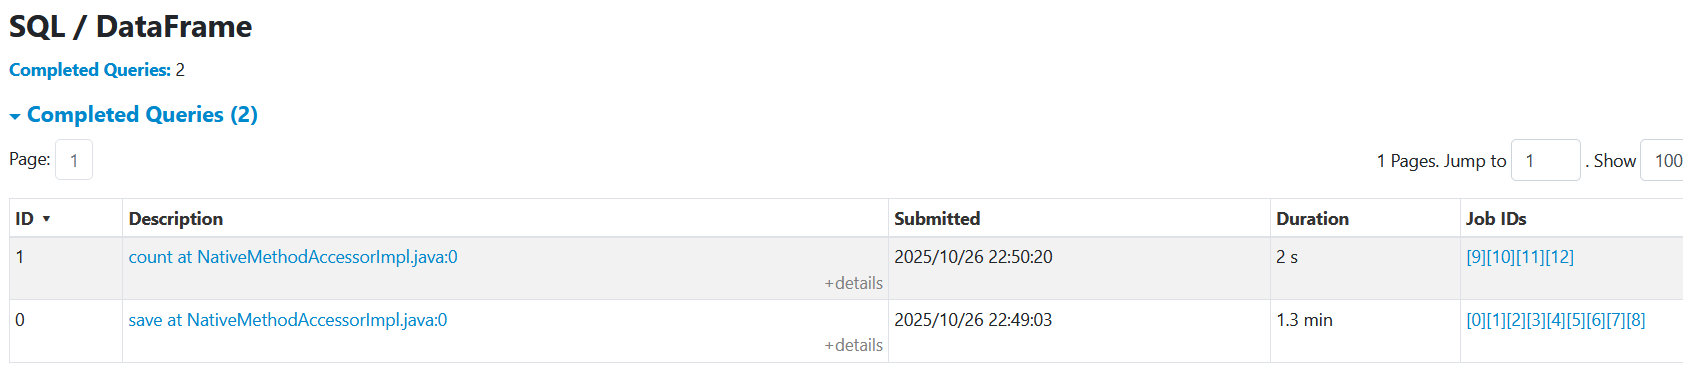

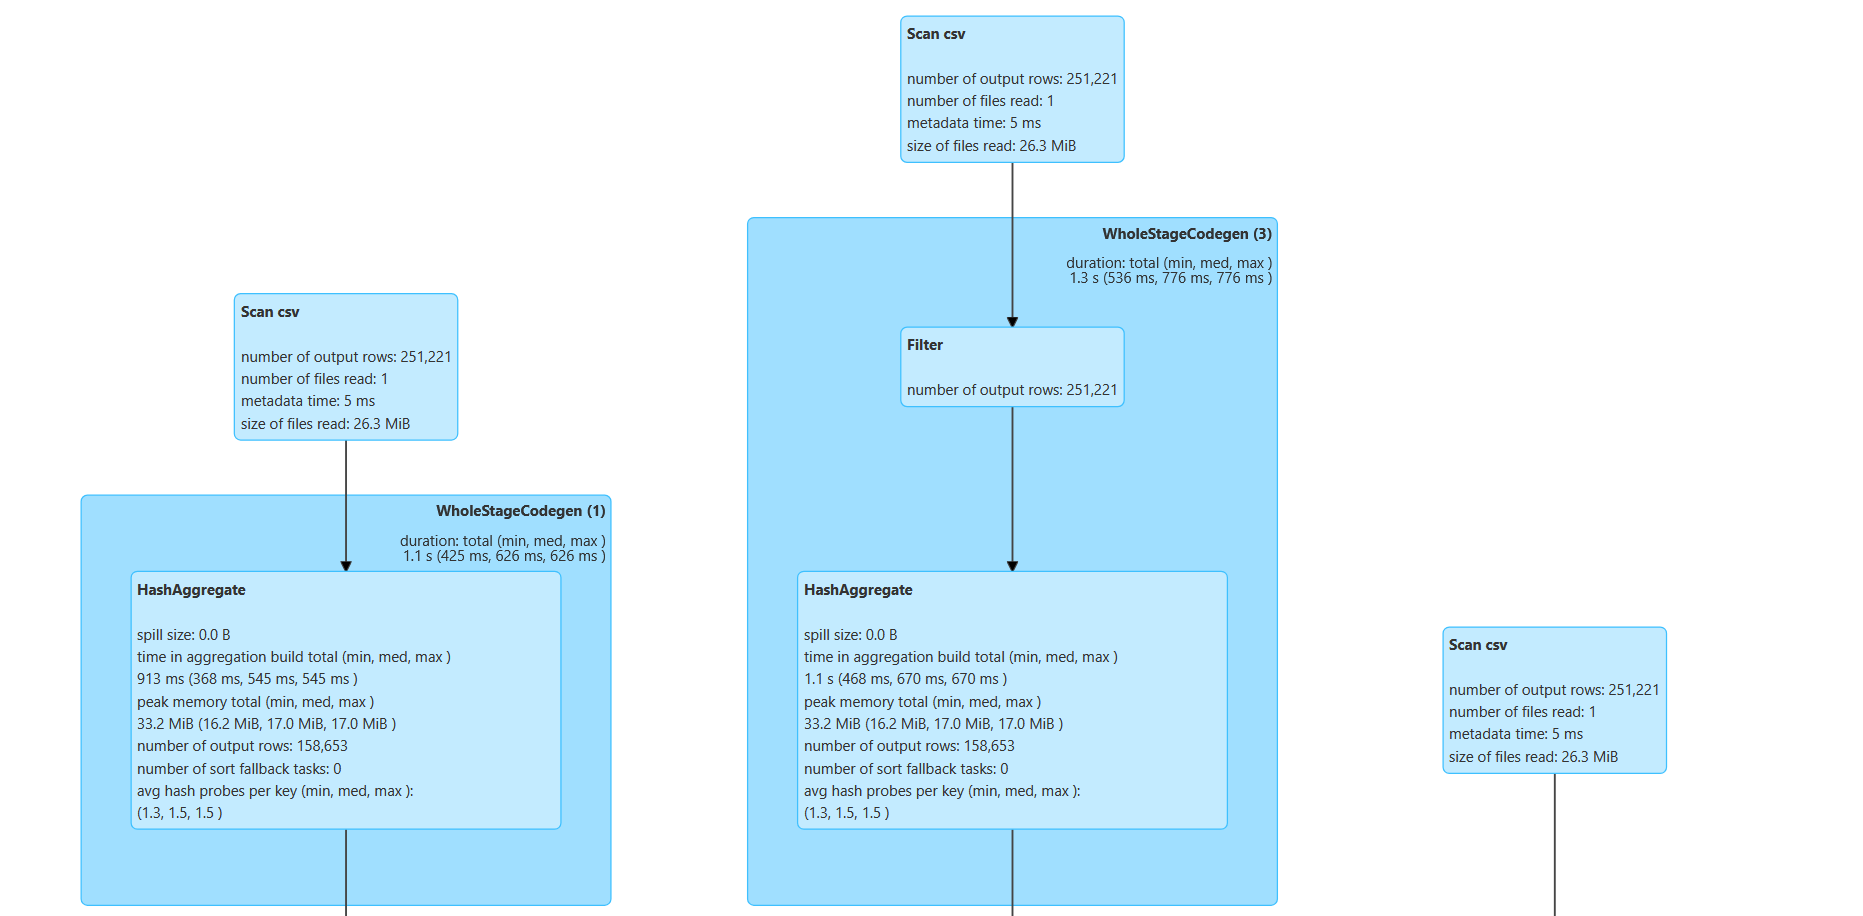
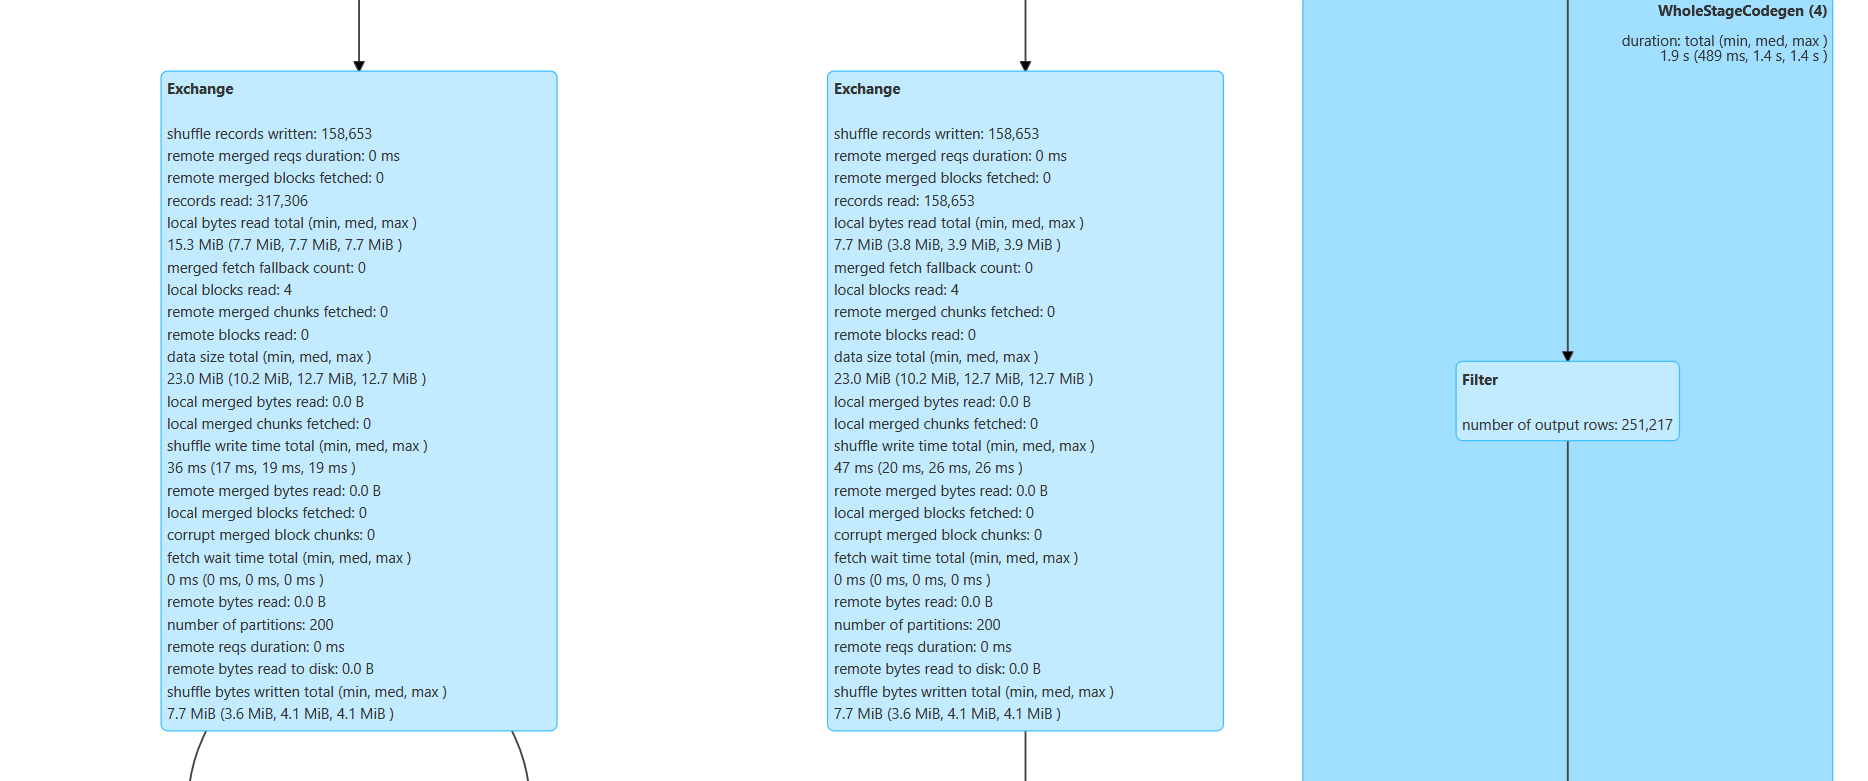
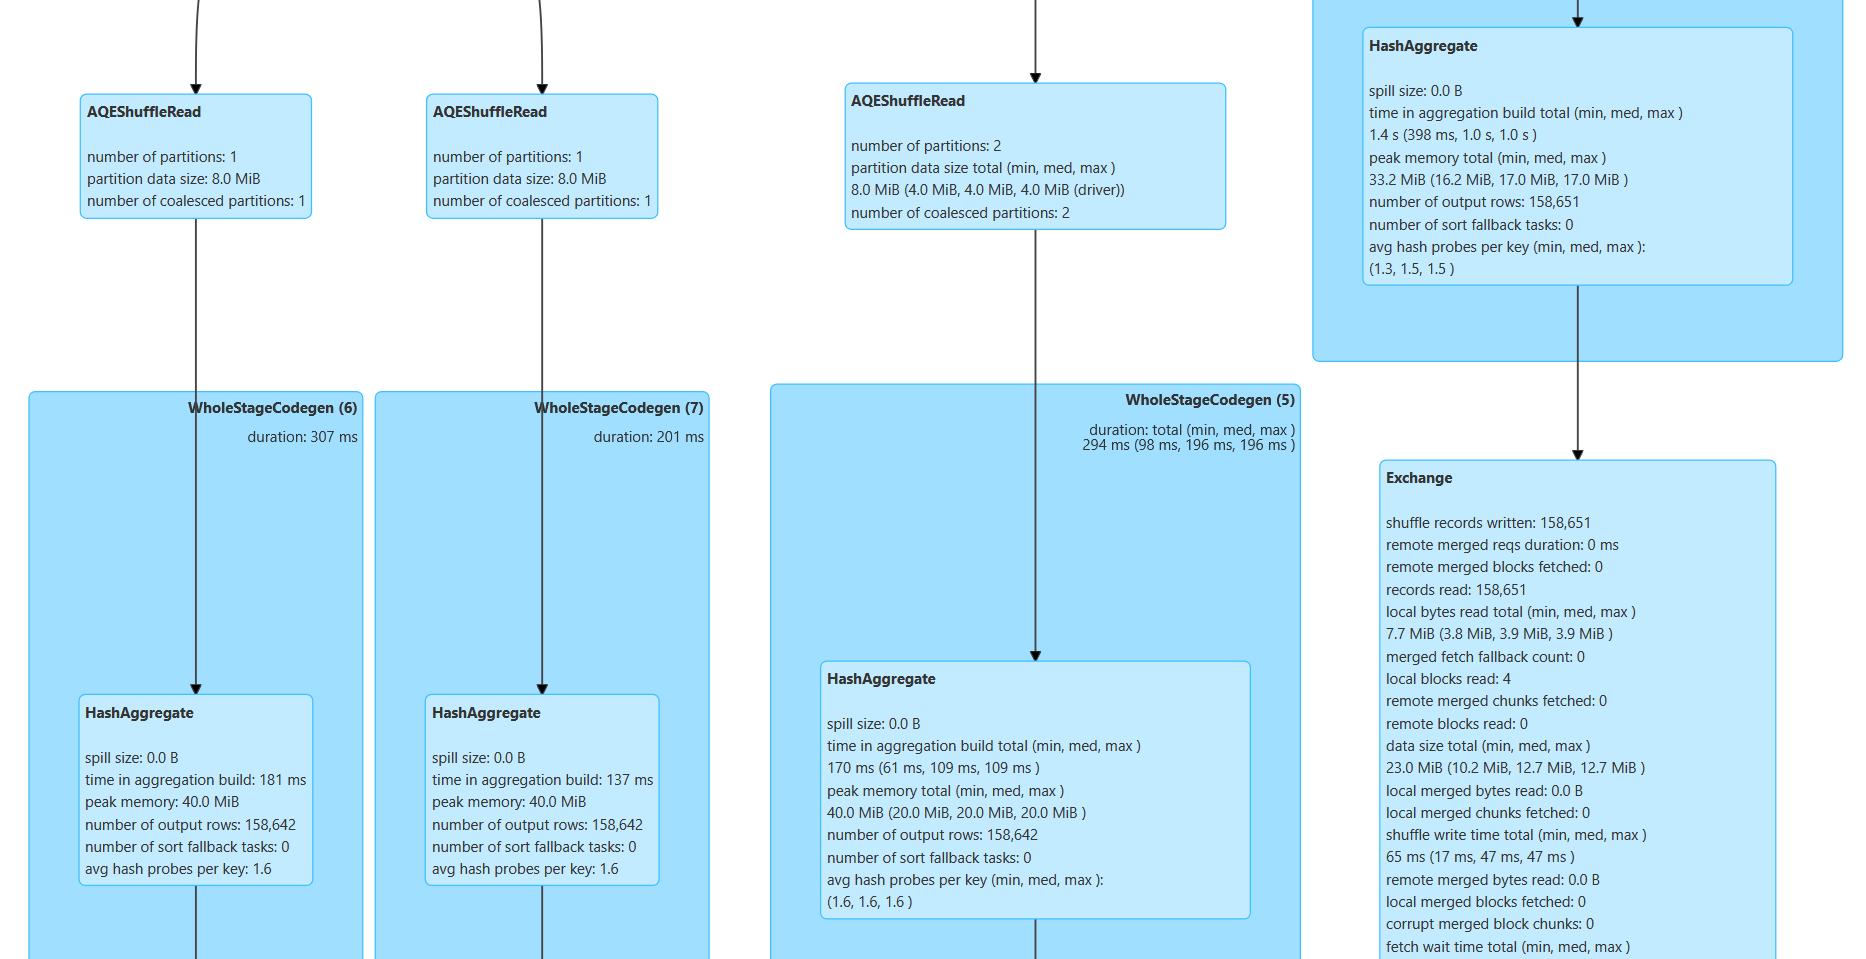
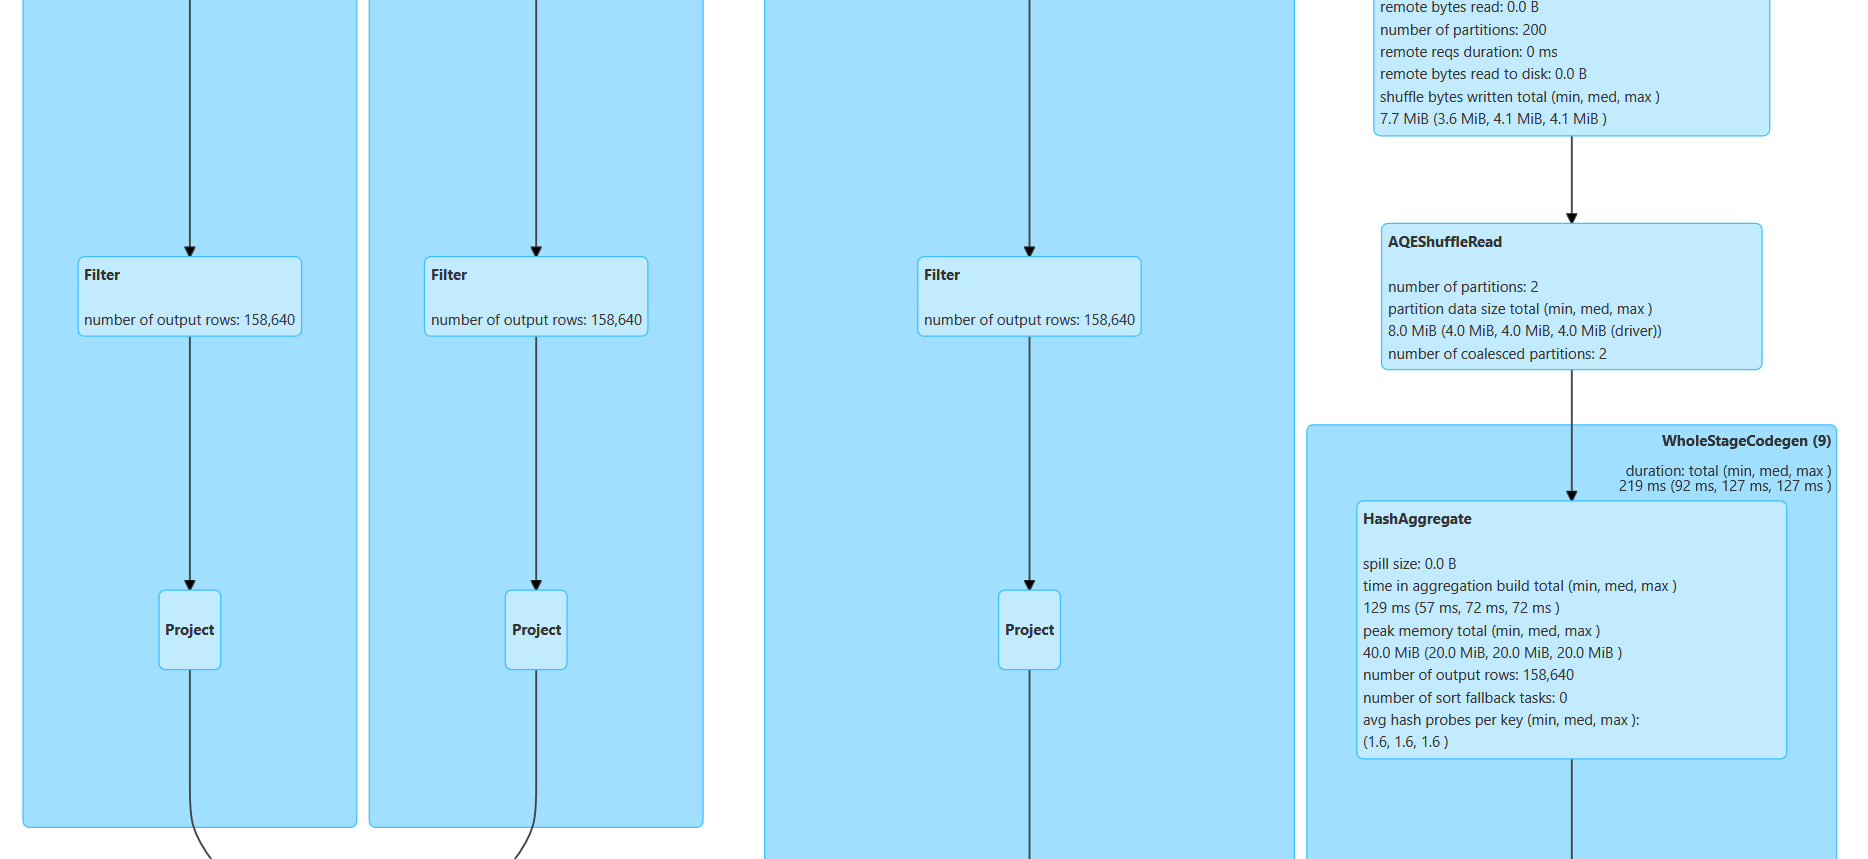
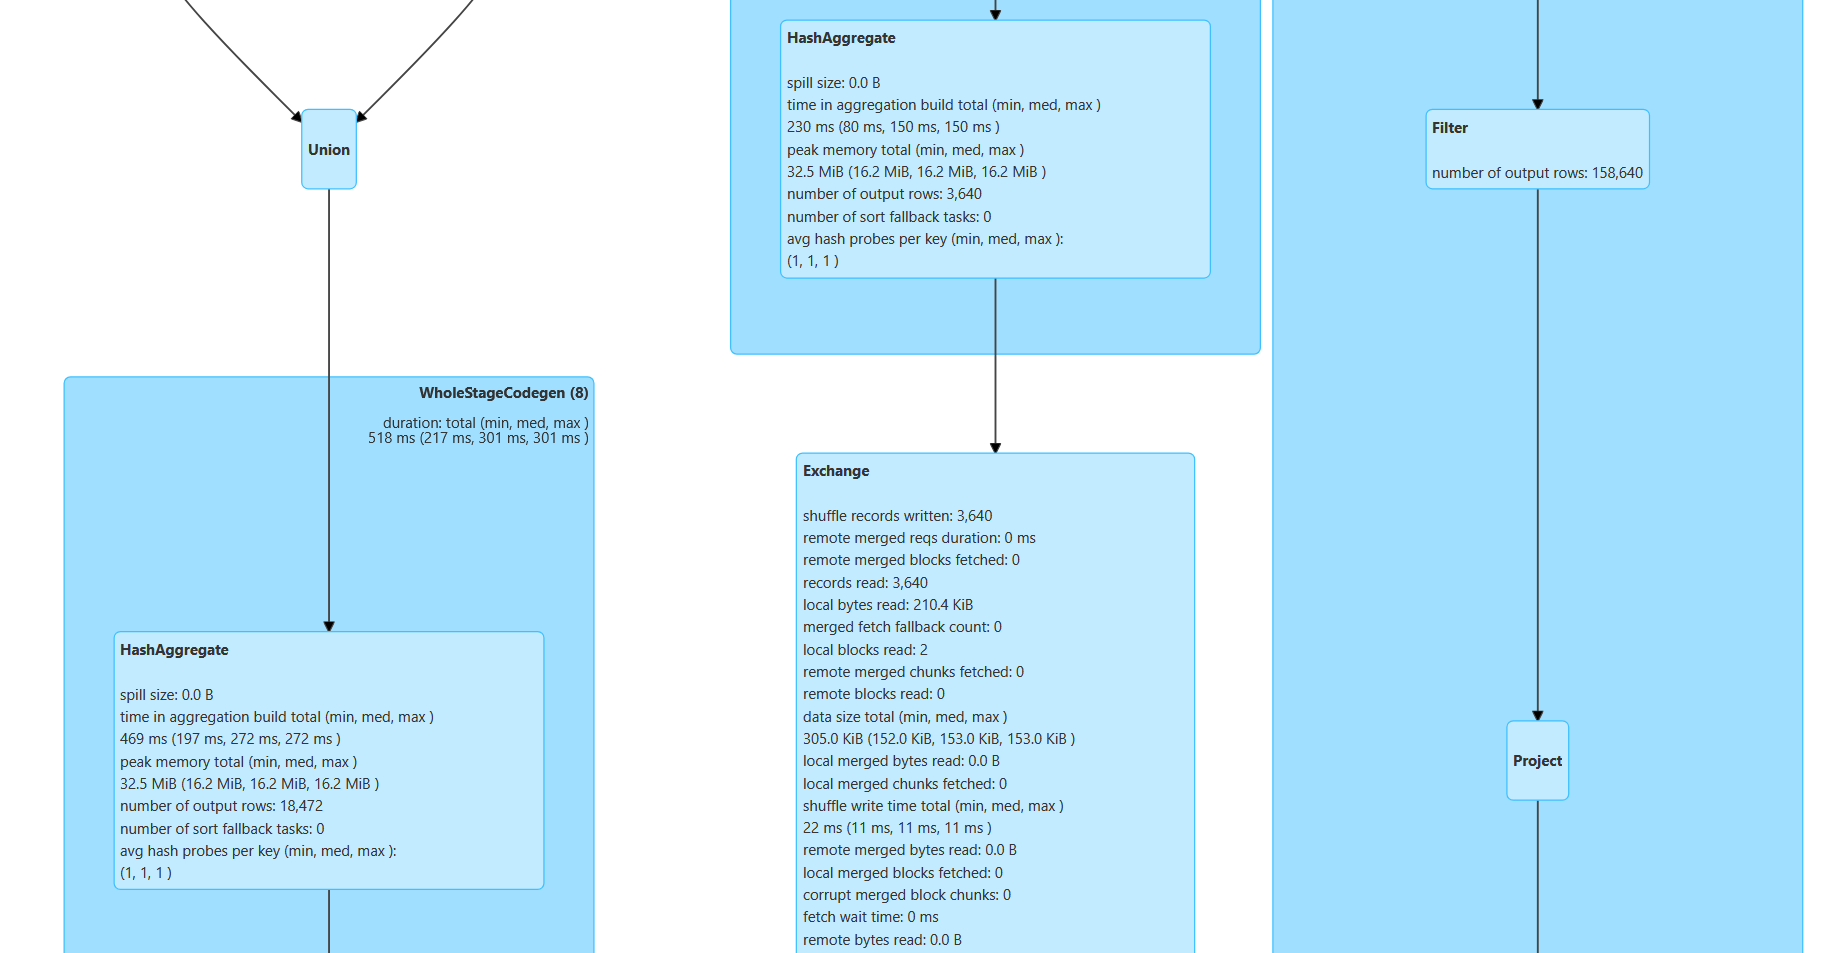
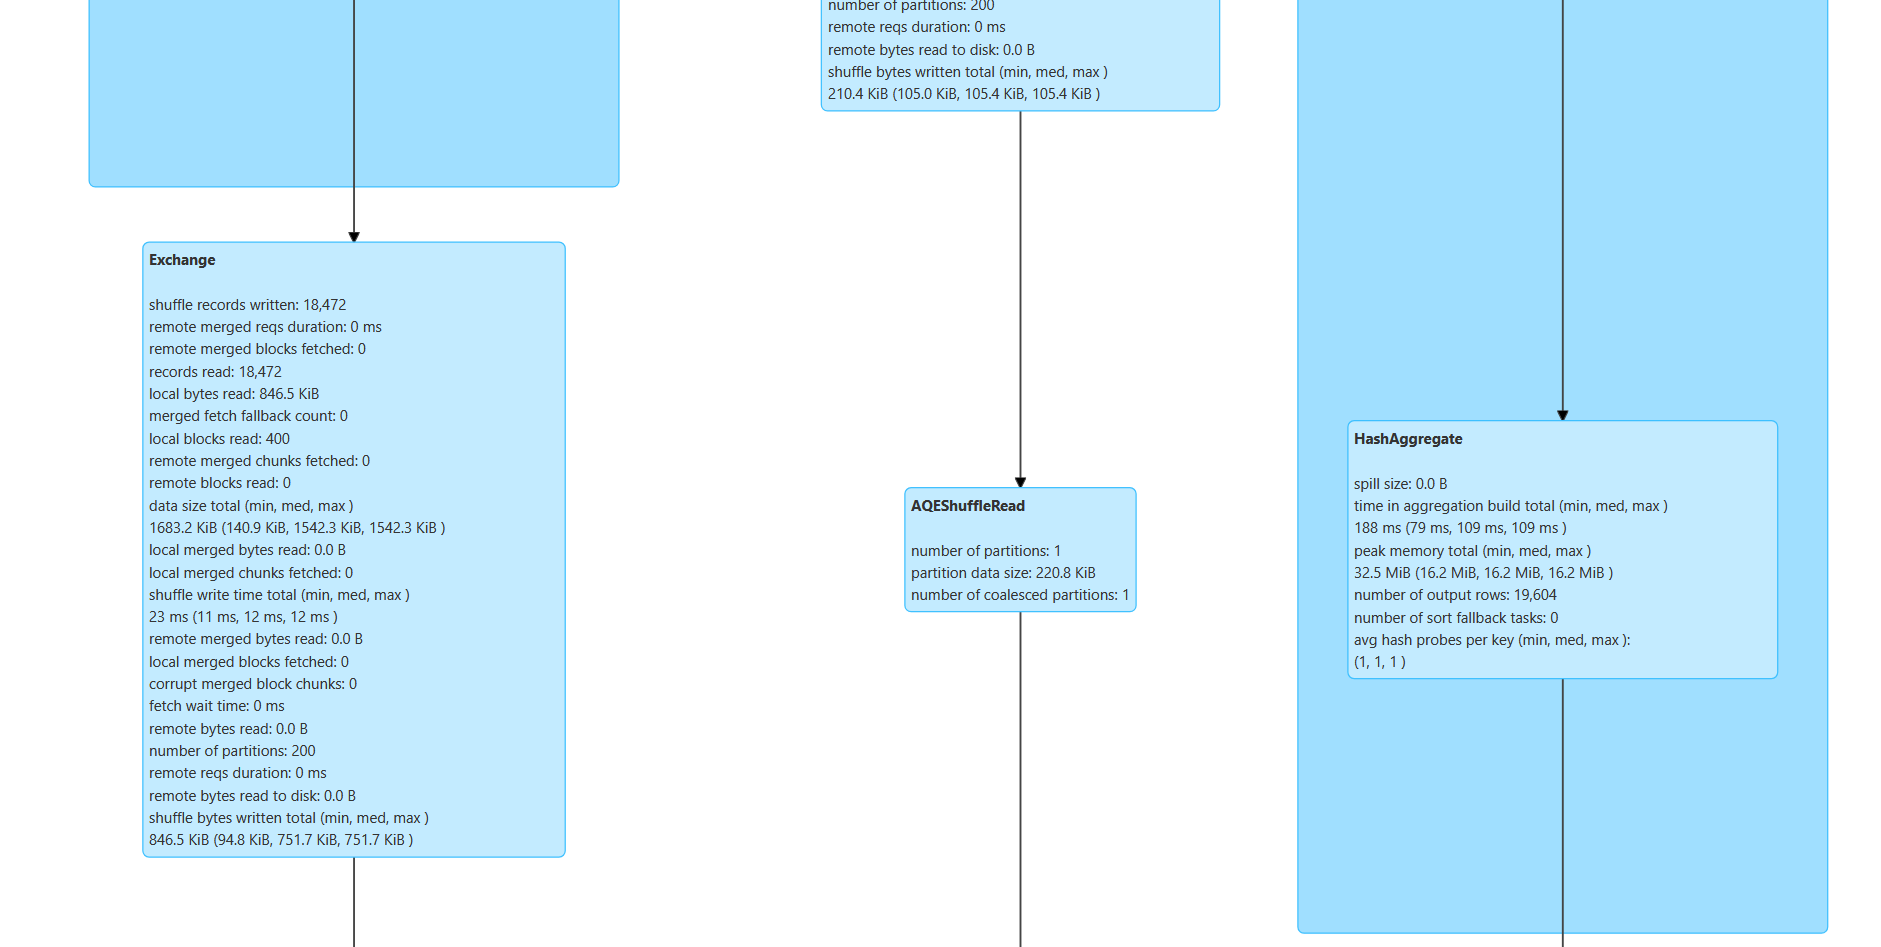
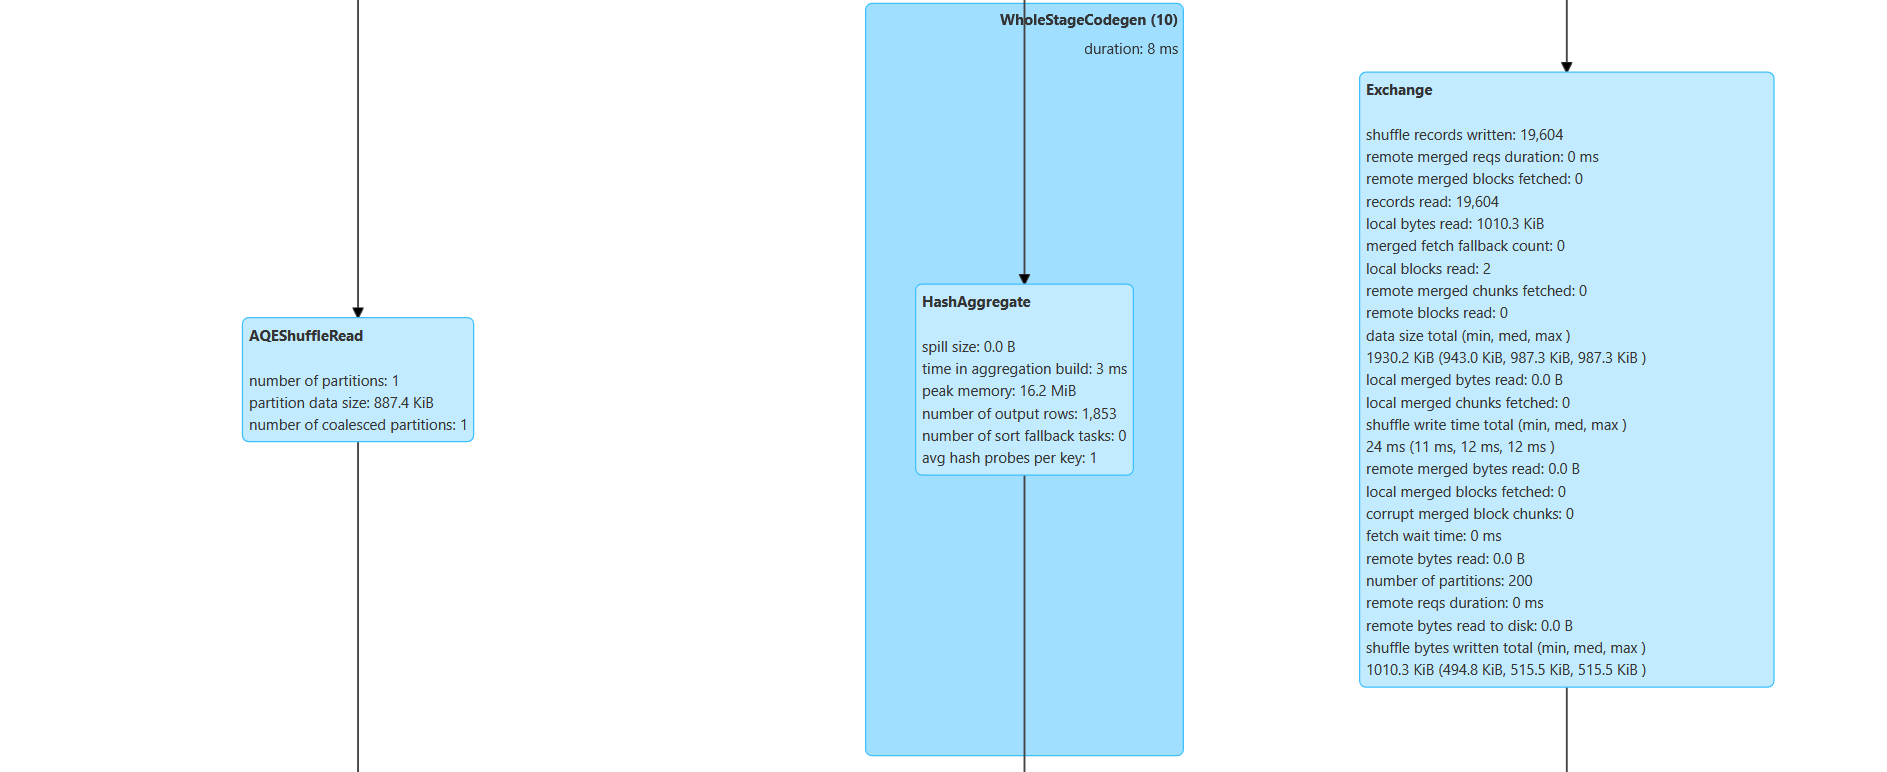
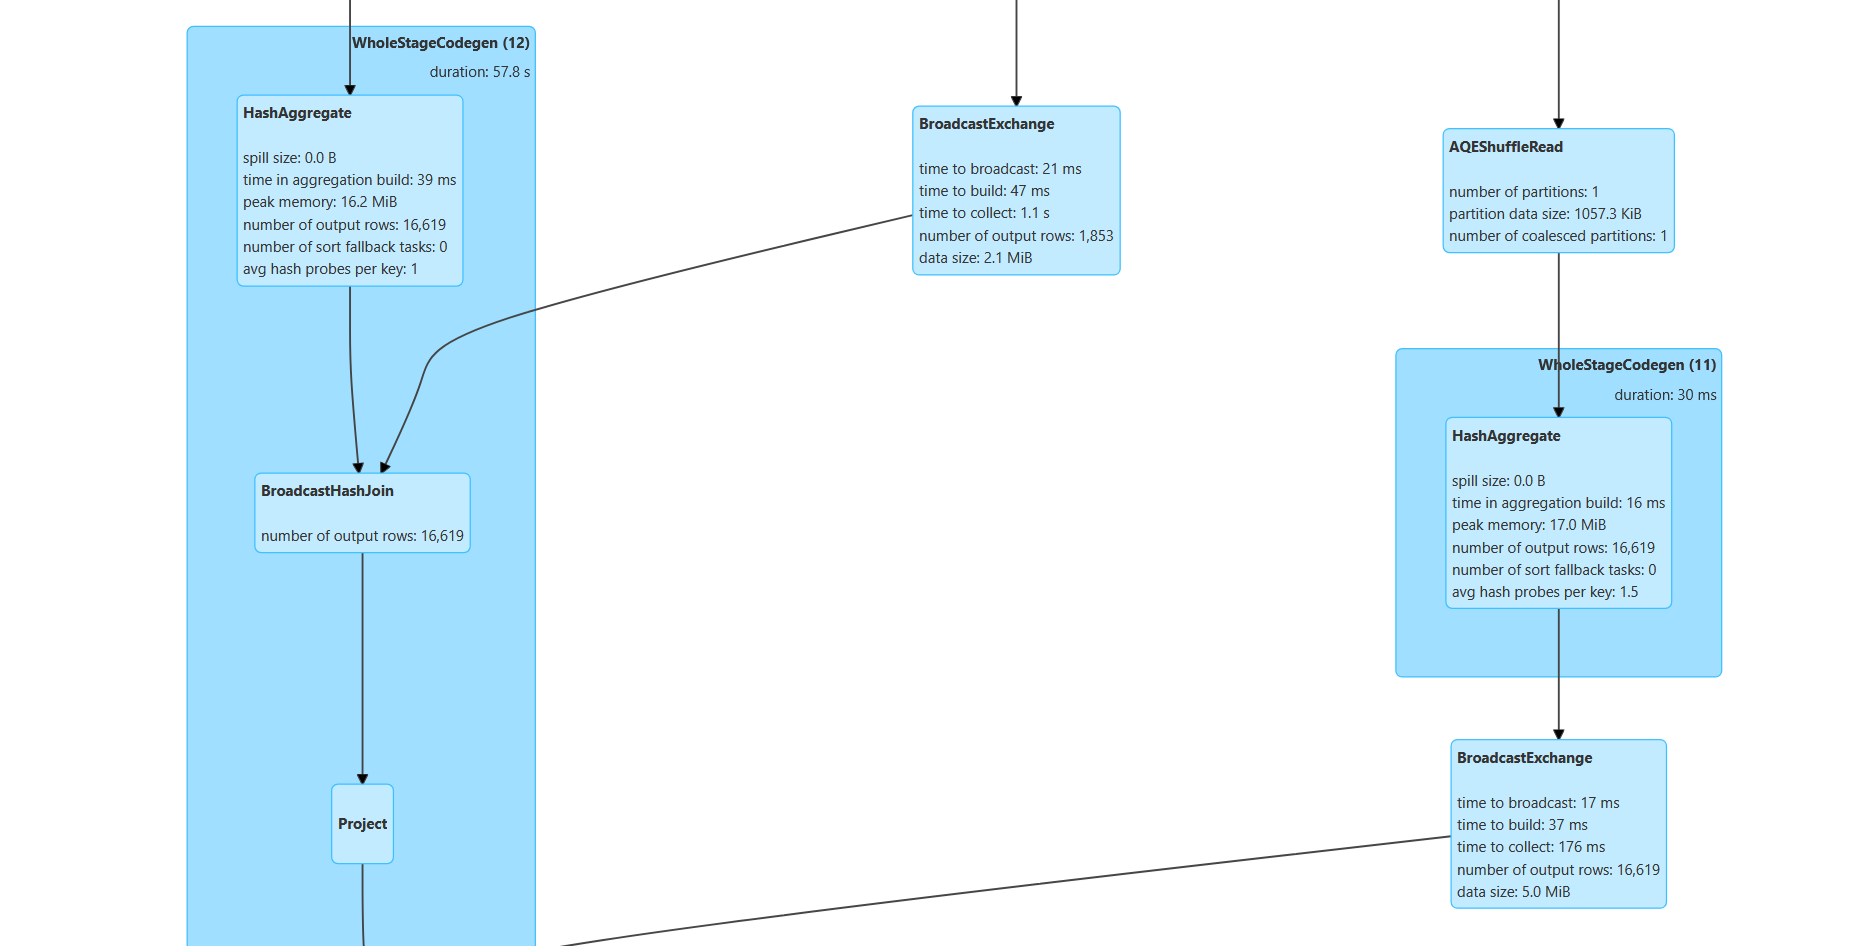
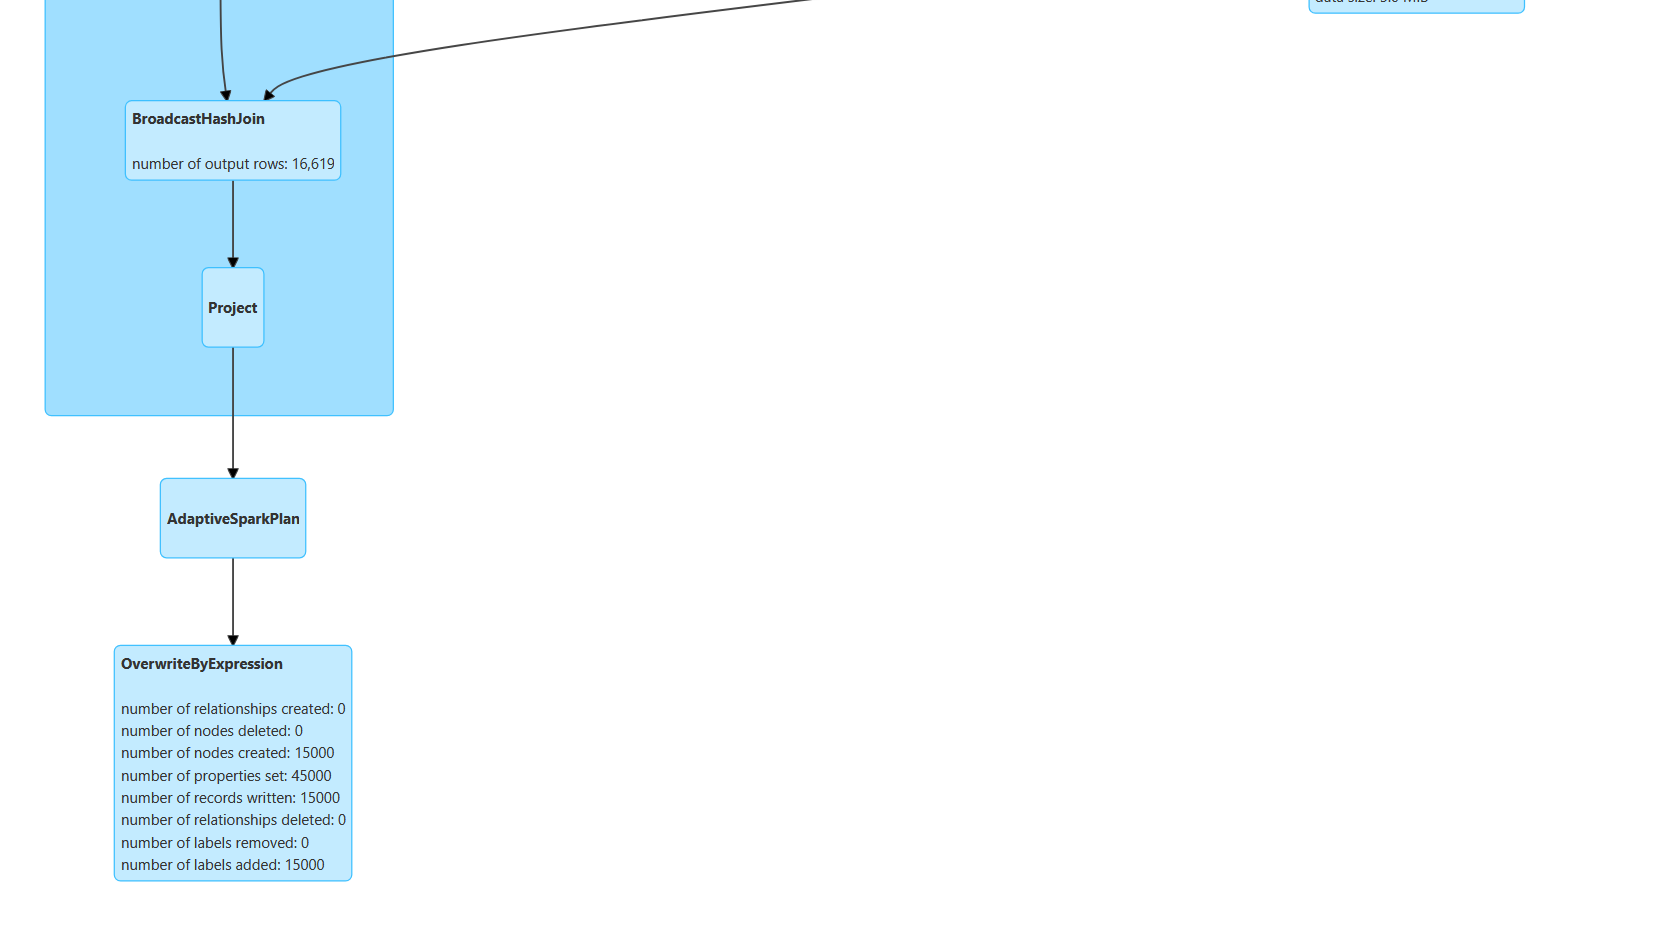

### Writing edges DAG
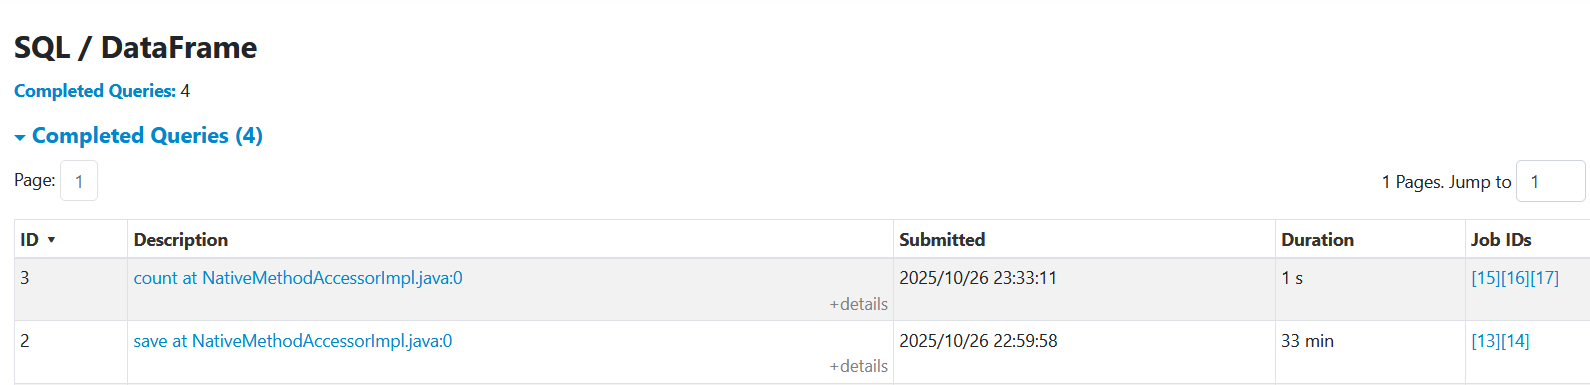

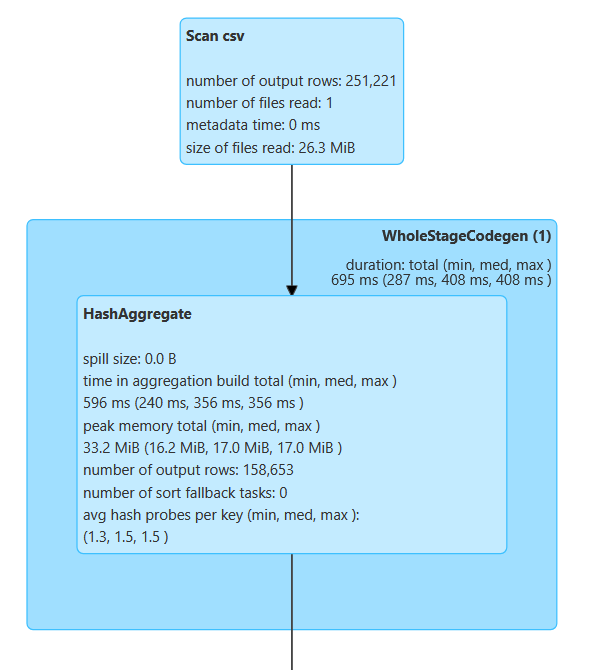
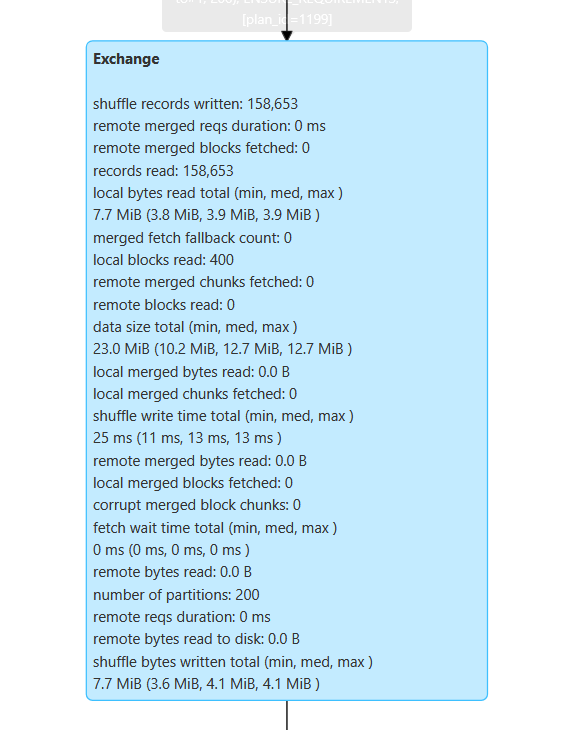
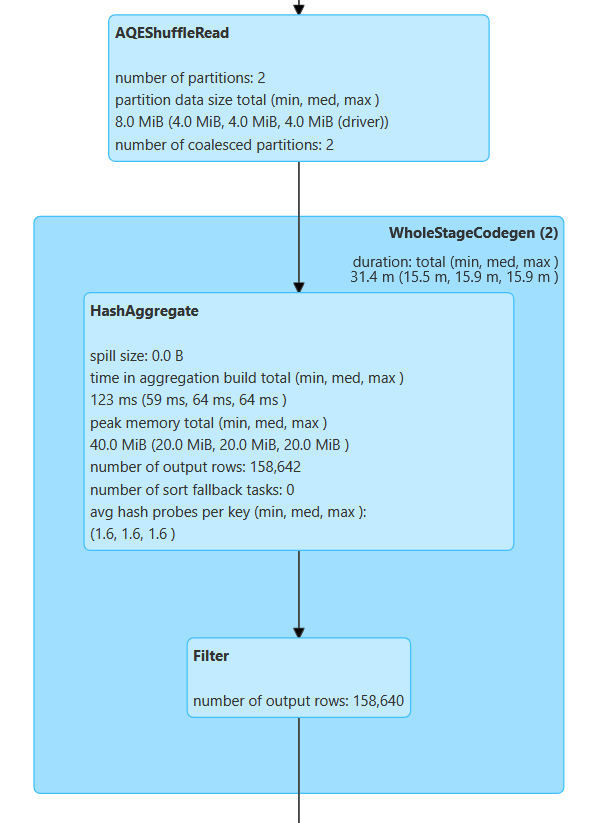
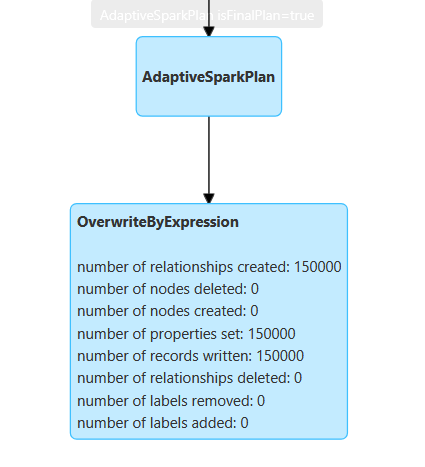
